In [85]:
import warnings
warnings.filterwarnings("ignore")

In [50]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv("C:\\Datasets\\diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


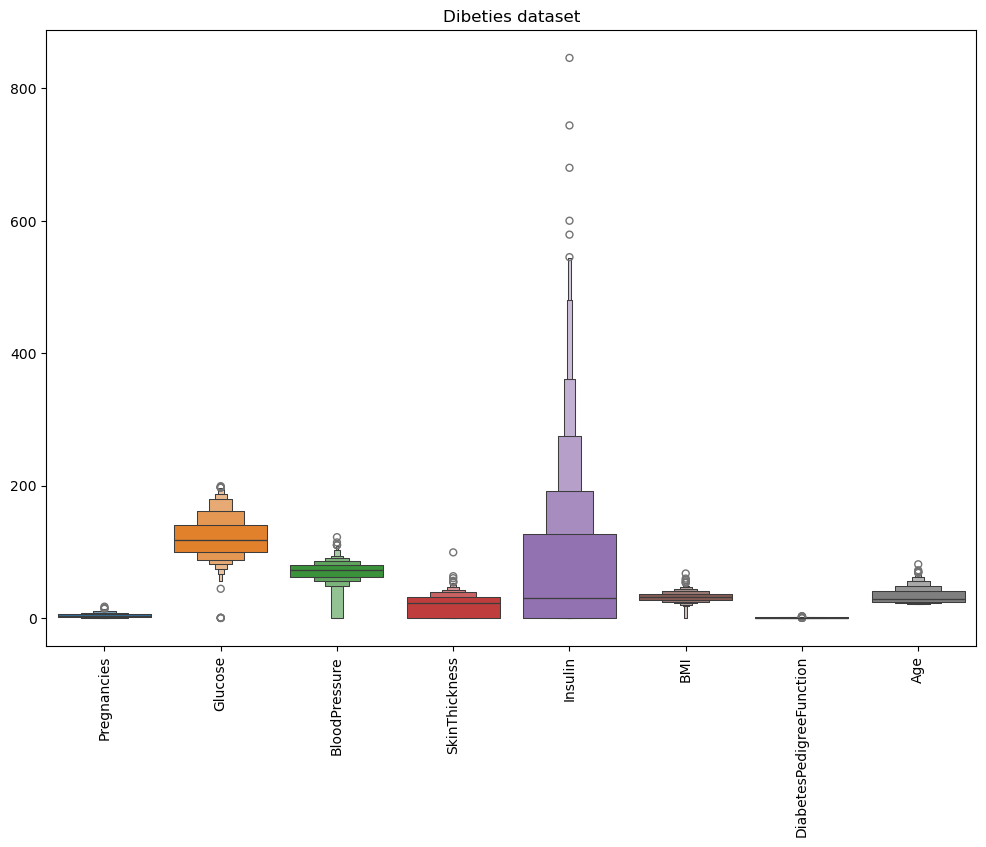

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.boxenplot(df.iloc[:,:-1]) # leaving last columns
plt.title("Dibeties dataset")
plt.xticks(rotation=90)
plt.show()

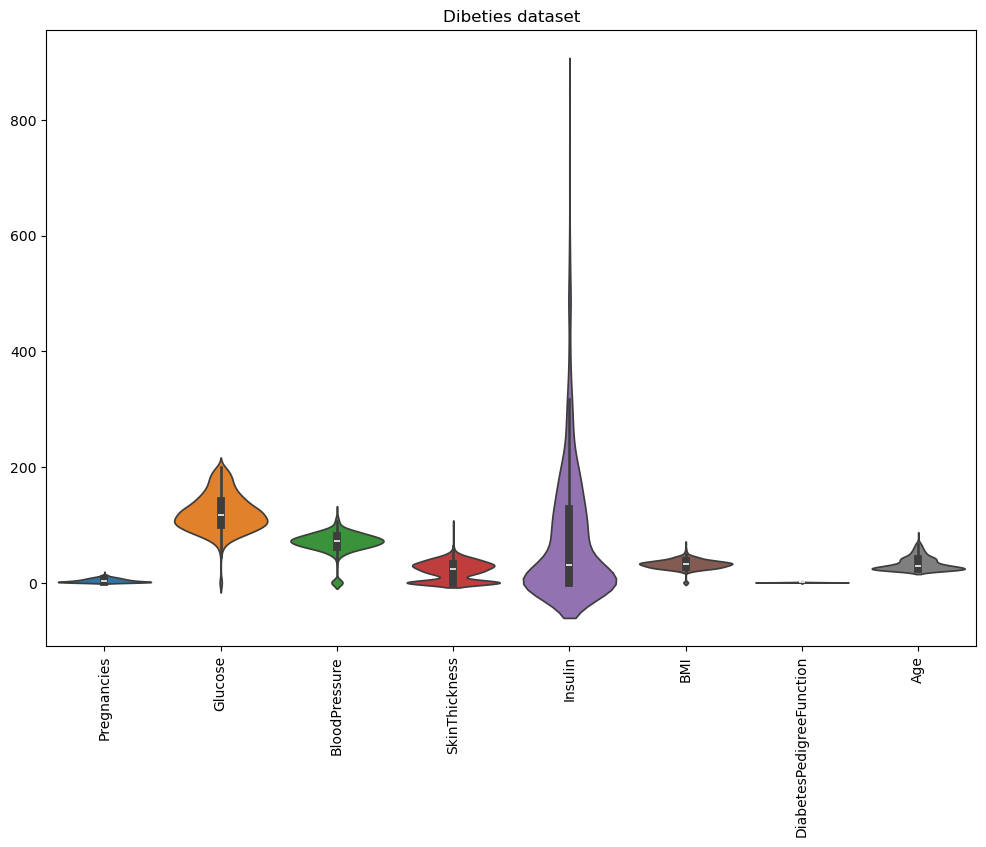

In [16]:
plt.figure(figsize=(12,8))
sns.violinplot(df.iloc[:,:-1]) # leaving last columns
plt.title("Dibeties dataset")
plt.xticks(rotation=90)
plt.show()

In [18]:
# Creating X and y dataset
X=df.drop(columns="Outcome")
y=df["Outcome"]

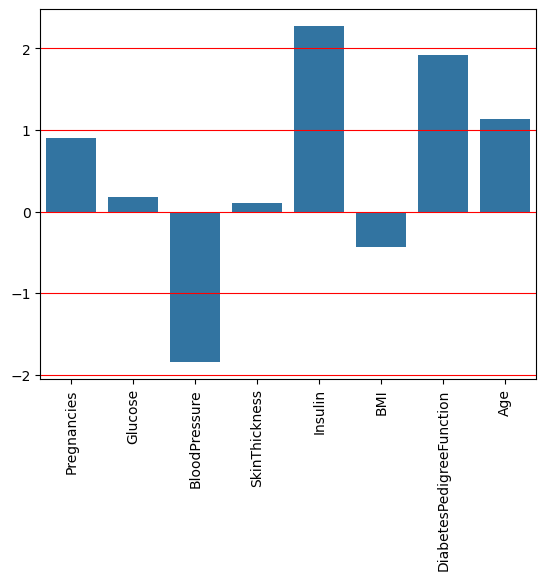

In [44]:
## Creating skewness chart

sns.barplot(X.skew())
plt.grid(True,which="both",axis="y",color="r", linestyle="-")
plt.xticks(rotation=90)
plt.show()

- As we can see data has both left and Right Skewness

<Axes: ylabel='Outcome'>

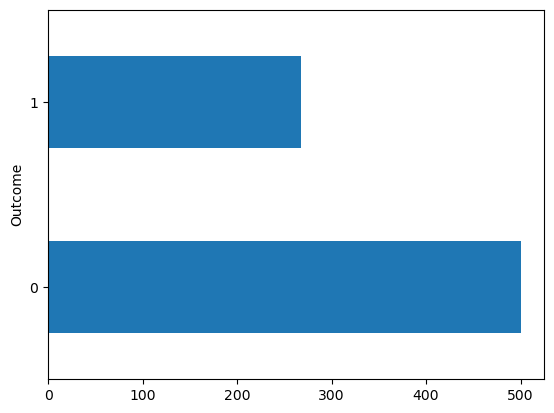

In [65]:
## Checking dissimlarities in output
y.value_counts().plot(kind="barh")

- Uneven data need to perform stratified split and ROC_AUC curve

### Splitting Train and Test dat

In [59]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_train.shape, X_test.shape

((614, 8), (154, 8))

### Applying Model which Do not get affected by Outliers and Skewness

In [54]:
# Dictnary of Models
model = {
    "XGB" : XGBClassifier(),
    "RandomForest" : RandomForestClassifier(),
    "Adaboost" : AdaBoostClassifier()
}

In [56]:
## Parameter Grid Dictnary
param_grid = {
    "RandomForest": {
        "n_estimators":[100,150,200],  
        "max_depth":[None,10,15,5], 
        "min_samples_split":[2,4,6,810], 
        "min_samples_leaf":[2,4],  
        "oob_score":[True], 
        "n_jobs":[-1] 
    },
    
    "XGB": {
        "verbosity":[2],
        "device":["cuda"],
        "eta":[0.2,0.3,0.4],
        "max_depth":[4,6,10]
    },
    "Adaboost": {
        "n_estimators":[50,100,150],
        "learning_rate":[0.5,1,5]
    }
}

In [77]:
best_model = {} # Expecting name and best model in each.
kcv = KFold(3) ## To keep same data set in each model with 3 validation test
for name,clf in model.items():
    gs = GridSearchCV(estimator=clf,
                      param_grid=param_grid[name],
                      n_jobs=-1,
                      return_train_score=True,
                      cv=kcv,
                      verbose=2)
    gs.fit(X_train,y_train)
    best_model[name] = gs.best_estimator_
    print(f"{name}\t->\t{gs.best_params_}")
    print(f"{name} accuracy : {gs.best_score_}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
XGB	->	{'device': 'cuda', 'eta': 0.2, 'max_depth': 4, 'verbosity': 2}
XGB accuracy : 0.7410489399011637
Fitting 3 folds for each of 96 candidates, totalling 288 fits
RandomForest	->	{'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150, 'n_jobs': -1, 'oob_score': True}
RandomForest accuracy : 0.7768850629682768
Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\rawat\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Adaboost	->	{'learning_rate': 0.5, 'n_estimators': 100}
Adaboost accuracy : 0.7622349752909293


In [87]:
print("Calculating Test Score in default")
for name,model in best_model.items():
    #calculating test accuracy
    print(f"{name} - Test accuracy : ",end=" ")
    print(model.score(X_test,y_test))
    

Calculating Test Score in default
XGB - Test accuracy :  0.7272727272727273
RandomForest - Test accuracy :  0.7662337662337663
Adaboost - Test accuracy :  0.7467532467532467


#### Plotting Roc AUC curve for better prediction

In [90]:
from sklearn.metrics import RocCurveDisplay, roc_curve,roc_auc_score

XGB -> AUC: 1.00


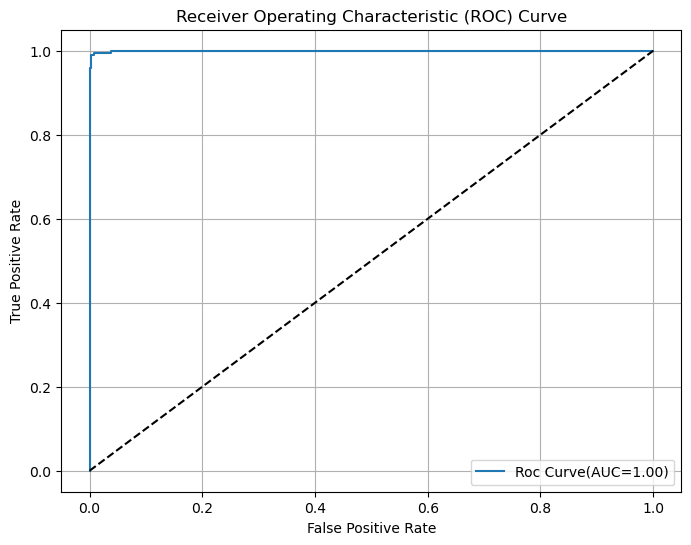


RandomForest -> AUC: 0.98


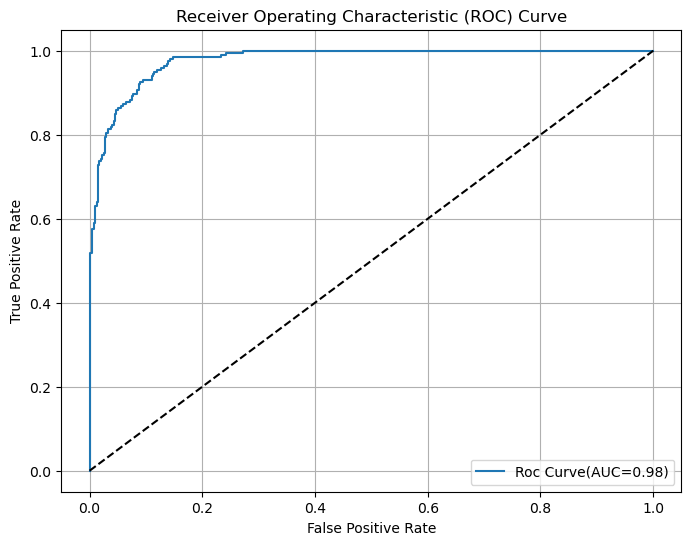


Adaboost -> AUC: 0.92


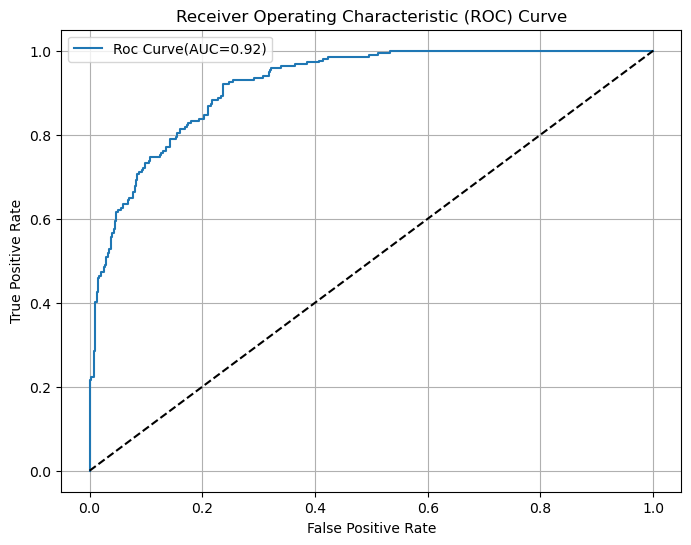

In [104]:
for name, model in best_model.items():

    ## Prediction of y value probability
    y_prob = model.predict_proba(X_train)[:,1] # this will take one value out of 2 columns

    ## For RoC Curve we required fpr, tpr
    fpr,tpr,thresholds = roc_curve(y_train,y_prob)

    # Calculate AUC 
    auc = roc_auc_score(y_train, y_prob) 
    print("="*30)
    print(f"{name} -> AUC: {auc:.2f}")

    #Plotting Graph
    plt.figure(figsize=(8,6))
    plt.plot(fpr,tpr,label=f"Roc Curve(AUC={auc:.2f})")
    plt.plot([0,1], [0,1],'k--') # diagonal
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title('Receiver Operating Characteristic (ROC) Curve') 
    plt.legend(loc='best') 
    plt.grid() 
    plt.show()
    print() # for extra space

#### For test

XGB -> AUC: 0.83


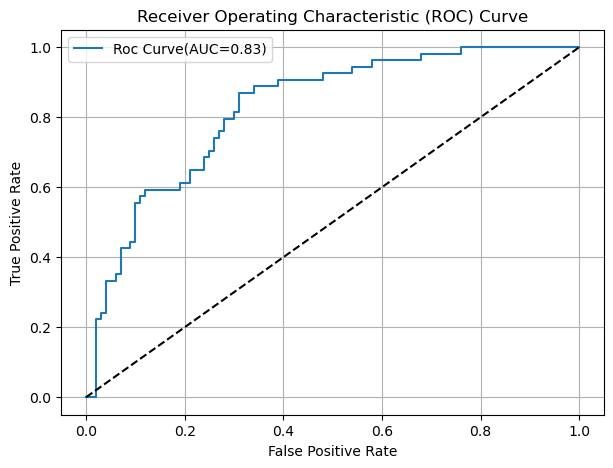


RandomForest -> AUC: 0.82


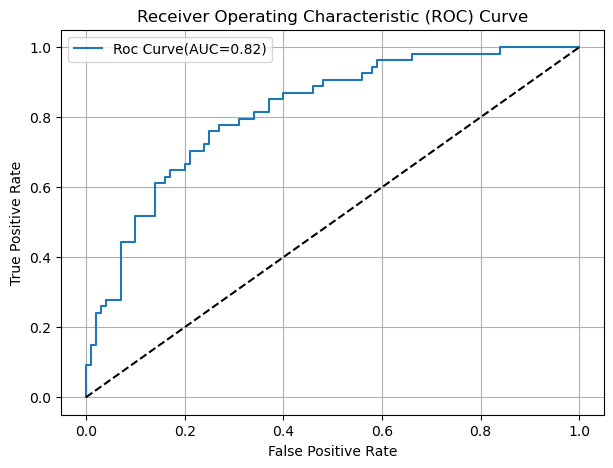


Adaboost -> AUC: 0.81


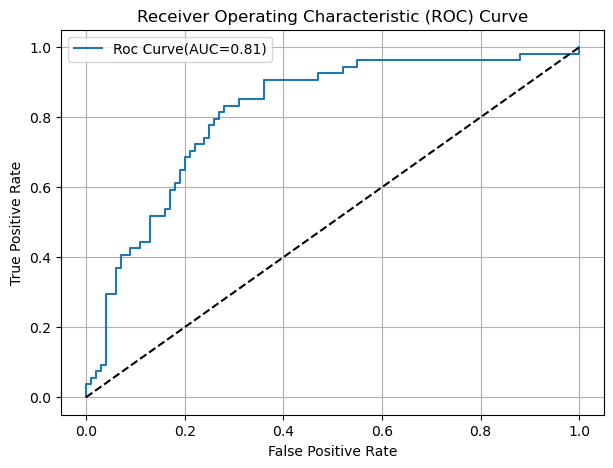

In [109]:
for name, model in best_model.items():

    ## Prediction of y value probability
    y_prob = model.predict_proba(X_test)[:,1] # this will take one value out of 2 columns

    ## For RoC Curve we required fpr, tpr
    fpr,tpr,thresholds = roc_curve(y_test,y_prob)

    # Calculate AUC 
    auc = roc_auc_score(y_test, y_prob) 
    print("="*30)
    print(f"{name} -> AUC: {auc:.2f}")

    #Plotting Graph
    plt.figure(figsize=(7,5))
    plt.plot(fpr,tpr,label=f"Roc Curve(AUC={auc:.2f})")
    plt.plot([0,1], [0,1],'k--') # diagonal
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title('Receiver Operating Characteristic (ROC) Curve') 
    plt.legend(loc='best') 
    plt.grid() 
    plt.show()
    print() # for extra space

- As we can see we have over fitted model

## Creating A Scaled Pipeline to Remove Skewness in data 

- There are few left skew data and right skew data.
- for Right skew -> Log Transformation
- for left skew -> Power Transformation
- Our objective is to Make a model which able to predict wether a person is dibetic or not
- so we need to focuse on False Negative.

In [116]:
## Seprating Left and Right skwe data
skew_feature = X_train.skew()
right_skew_columns = skew_feature[skew_feature>0.8].index
left_skew_columns = skew_feature[skew_feature<-0.8].index

print(f" - Right Skew : {right_skew_columns}")
print(f" - Left Skew : {left_skew_columns}")

Right Skew : Index(['Pregnancies', 'Insulin', 'DiabetesPedigreeFunction', 'Age'], dtype='object')
Left Skew : Index(['BloodPressure'], dtype='object')


### Pipeline: 
- skew_processor -> Standard Scalar -> Grid Search cv -> Models

In [137]:
# Creating custom Transfomer
log_transformer = FunctionTransformer(np.log1p, validate=True) 
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson')

# For Processing Skewness
skew_process = ColumnTransformer([
    ("log", log_transformer, right_skew_columns),
    ("yeo_johnson", yeo_johnson_transformer, left_skew_columns)],
    remainder="passthrough")

## Creating Pipeline with GridSearchCV

In [149]:
# Dictnary of Models
model = {
    "XGB" : XGBClassifier(),
    "RandomForest" : RandomForestClassifier(),
    "Adaboost" : AdaBoostClassifier(),
    "SVC" : SVC(),
    "Logistic Regression" : LogisticRegression()
}

## Parameter Grid Dictnary
param_grid = {
    "RandomForest": {
        "RandomForest__n_estimators": [100, 150, 200],  
        "RandomForest__max_depth": [None, 10, 15, 5], 
        "RandomForest__min_samples_split": [2, 4, 6, 8], 
        "RandomForest__min_samples_leaf": [2, 4],  
        "RandomForest__oob_score": [True], 
        "RandomForest__n_jobs": [-1] 
    },
    "XGB": {
        "XGB__verbosity": [2],
        "XGB__eta": [0.2, 0.3, 0.4],
        "XGB__max_depth": [4, 6, 10],
        "XGB__tree_method": ["gpu_hist"],  # Specify to use GPU
        "XGB__gpu_id": [0]  # Specify which GPU to use
    },
    "Adaboost": {
        "Adaboost__n_estimators": [50, 100, 150],
        "Adaboost__learning_rate": [0.5, 1, 5]
    },
    "SVC": {
        "SVC__C": [0.1, 0.4, 1, 10]
    },
    "Logistic Regression": {
        "Logistic Regression__C": [0.1, 0.4, 1, 10],
        "Logistic Regression__solver": ["lbfgs", "liblinear"]
    }
}

# Define cross-validation strategy
kcv = KFold(n_splits=5, shuffle=True, random_state=42)

In [151]:
best_pipeline = {}
for name,clf in model.items():
    # creating Pipeline per model
    pipeline = Pipeline([
        ("Skew_Transformer", skew_process),
        ("Standard Scalar", StandardScaler()),
        (name,clf)
    ])

    #Creating GridSearch model
    gs = GridSearchCV(estimator=pipeline,
                      param_grid=param_grid[name],
                      n_jobs=-1,
                      return_train_score=True,
                      cv=kcv,
                      verbose=2)

    # Fitting Model to dataset
    gs.fit(X_train,y_train)
    
    best_pipeline[name] = gs.best_estimator_

    #Display output
    print(f"{name}\t->\t{gs.best_params_}")
    print(f"{name} accuracy : {gs.best_score_}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
XGB	->	{'XGB__eta': 0.4, 'XGB__gpu_id': 0, 'XGB__max_depth': 10, 'XGB__tree_method': 'gpu_hist', 'XGB__verbosity': 2}
XGB accuracy : 0.7394642143142743
Fitting 5 folds for each of 96 candidates, totalling 480 fits
RandomForest	->	{'RandomForest__max_depth': 5, 'RandomForest__min_samples_leaf': 4, 'RandomForest__min_samples_split': 8, 'RandomForest__n_estimators': 200, 'RandomForest__n_jobs': -1, 'RandomForest__oob_score': True}
RandomForest accuracy : 0.7752099160335866
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Adaboost	->	{'Adaboost__learning_rate': 0.5, 'Adaboost__n_estimators': 50}
Adaboost accuracy : 0.7751566040250567
Fitting 5 folds for each of 4 candidates, totalling 20 fits
SVC	->	{'SVC__C': 10}
SVC accuracy : 0.7556710649073703
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Logistic Regression	->	{'Logistic Regression__C': 10, 'Logistic Regression__solver': 'lbfgs'}
Logistic Regression a

## Creating ROC AUC Curve for following models

### For Train data

XGB -> AUC: 1.00


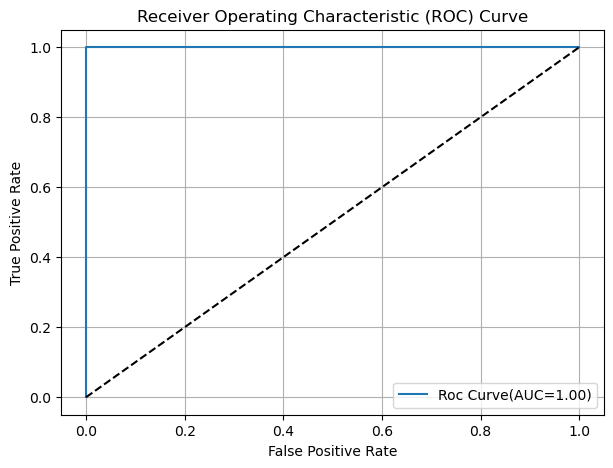


RandomForest -> AUC: 0.93


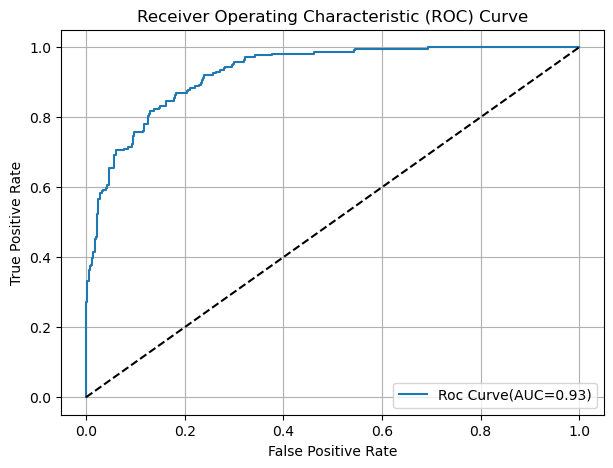


Adaboost -> AUC: 0.90


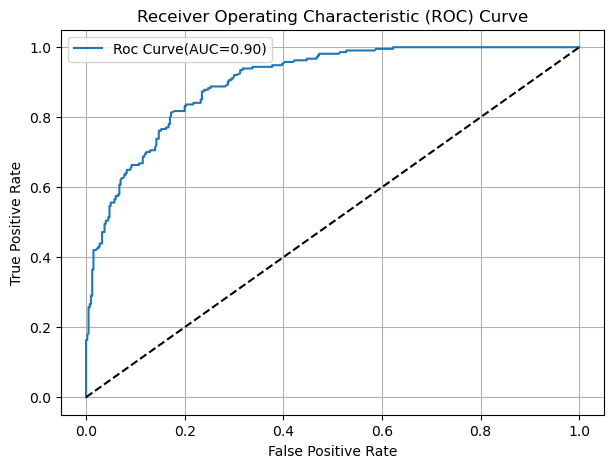


Logistic Regression -> AUC: 0.84


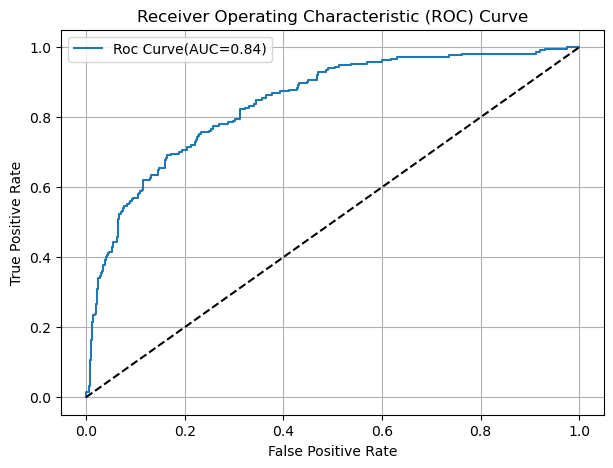

In [165]:
for name, model in best_pipeline.items():

    if name=="SVC": continue

    ## Prediction of y value probability
    y_prob = model.predict_proba(X_train)[:,1] # this will take one value out of 2 columns

    ## For RoC Curve we required fpr, tpr
    fpr,tpr,thresholds = roc_curve(y_train,y_prob)

    # Calculate AUC 
    auc = roc_auc_score(y_train, y_prob) 
    print("="*30)
    print(f"{name} -> AUC: {auc:.2f}")

    #Plotting Graph
    plt.figure(figsize=(7,5))
    plt.plot(fpr,tpr,label=f"Roc Curve(AUC={auc:.2f})")
    plt.plot([0,1], [0,1],'k--') # diagonal
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title('Receiver Operating Characteristic (ROC) Curve') 
    plt.legend(loc='best') 
    plt.grid() 
    plt.show()
    print() # for extra space

### For Test data

XGB -> AUC: 0.82


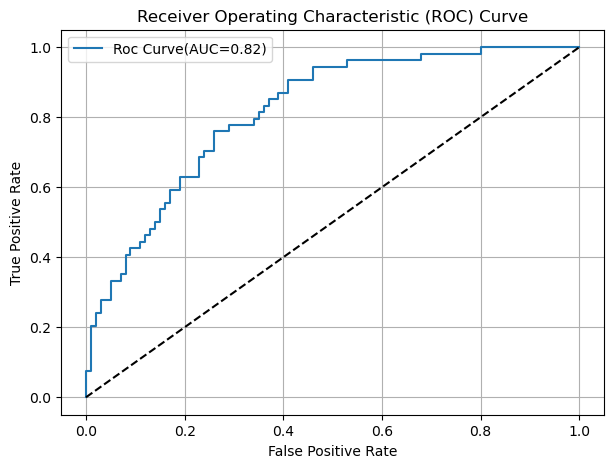


RandomForest -> AUC: 0.81


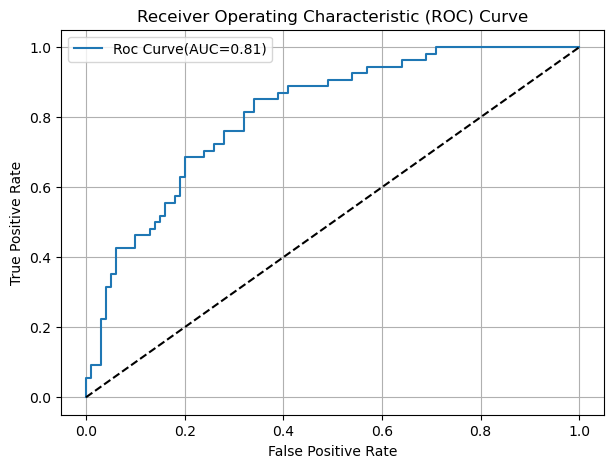


Adaboost -> AUC: 0.84


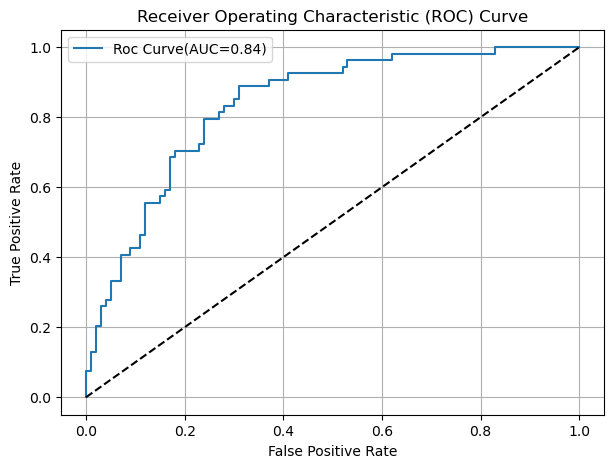


Logistic Regression -> AUC: 0.83


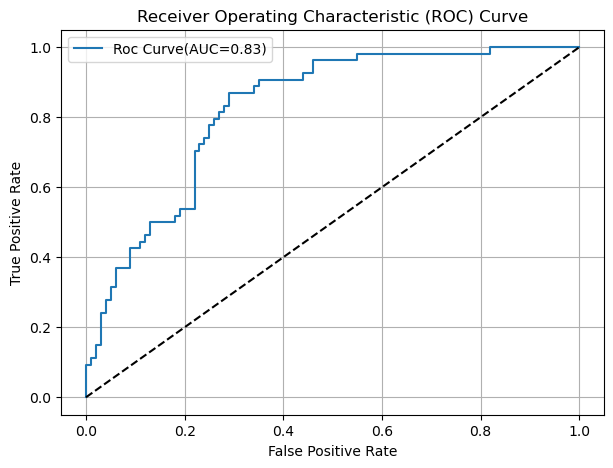

In [156]:
## For Test data
for name, model in best_pipeline.items():

    ## Prediction of y value probability
    if name == "SVC":
        continue
    y_prob = model.predict_proba(X_test)[:,1] # this will take one value out of 2 columns

    ## For RoC Curve we required fpr, tpr
    fpr,tpr,thresholds = roc_curve(y_test,y_prob)

    # Calculate AUC 
    auc = roc_auc_score(y_test, y_prob) 
    print("="*30)
    print(f"{name} -> AUC: {auc:.2f}")

    #Plotting Graph
    plt.figure(figsize=(7,5))
    plt.plot(fpr,tpr,label=f"Roc Curve(AUC={auc:.2f})")
    plt.plot([0,1], [0,1],'k--') # diagonal
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title('Receiver Operating Characteristic (ROC) Curve') 
    plt.legend(loc='best') 
    plt.grid() 
    plt.show()
    print() # for extra space

### Creating a model with least FN -> Recall

- Selecting ADA Boost as it has moderate Train and Test AUC SCORE
- We want High Recall because we need high recall.
- Higher Recall mean that low FN,
- FN is Unable to Identified Person with dibeties

In [170]:
## Creating a dataframe with different threshold
y_prob = best_pipeline["Adaboost"].predict_proba(X_train)[:,1]
prob_df = pd.DataFrame({"Y_true":y_train,
                       "Y_prob":y_prob})
prob_df.head()

,Y_true,Y_prob
353,0,0.456630
711,0,0.501361
373,0,0.476853
46,0,0.498927
682,0,0.481481


In [198]:
for th in np.arange(0.1, 1.1, 0.05): 
    prob_df[f'th_{th:.2f}'] = (prob_df['Y_prob'] > th).astype(int) 

prob_df.sample(5)

,Y_true,Y_prob,th_0.1,th_0.2,th_0.3,th_0.4,th_0.5,th_0.6,th_0.7,th_0.8,...,th_0.60,th_0.65,th_0.70,th_0.75,th_0.80,th_0.85,th_0.90,th_0.95,th_1.00,th_1.05
653,0,0.473468,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
457,0,0.465082,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
209,1,0.532285,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
203,0,0.452654,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
318,0,0.486026,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [202]:
for th in np.arange(0.45, 0.51, 0.01): 
    prob_df[f'th_{th:.2f}'] = (prob_df['Y_prob'] > th).astype(int) 

prob_df.sample(5)

,Y_true,Y_prob,th_0.1,th_0.2,th_0.3,th_0.4,th_0.5,th_0.6,th_0.7,th_0.8,...,th_0.80,th_0.85,th_0.90,th_0.95,th_1.00,th_1.05,th_0.46,th_0.47,th_0.48,th_0.49
337,1,0.500120,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,1,1,1,1
403,0,0.472831,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
35,0,0.475765,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
93,1,0.479584,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
465,0,0.457983,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [204]:
from collections import defaultdict

scores = defaultdict(list) # default dict with list
for th_col in prob_df.columns:
    # to skip these columns
    if th_col in ["Y_true","Y_prob"]:continue
    
    true_positives = ((prob_df['Y_true'] == 1) & (prob_df[th_col] == 1)).sum()
    false_positives = ((prob_df['Y_true'] == 0) & (prob_df[th_col] == 1)).sum()
    false_negatives = ((prob_df['Y_true'] == 1) & (prob_df[th_col] == 0)).sum()
    
    # Recall
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    scores[th_col].append(recall)
    
    #Precision
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0 
    scores[th_col].append(precision)

    #F1_score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    scores[th_col].append(f1_score)

# Display recall scores
for th_col, values in scores.items():
    print()
    recall, precision, f1_score = values
    print(f'{th_col}-> Recall: {recall:.2f}, Precison: {precision:.2f}, F1_score: {f1_score:.2f}')



th_0.1-> Recall: 1.00, Precison: 0.35, F1_score: 0.52

th_0.2-> Recall: 1.00, Precison: 0.35, F1_score: 0.52

th_0.3-> Recall: 1.00, Precison: 0.35, F1_score: 0.52

th_0.4-> Recall: 1.00, Precison: 0.35, F1_score: 0.52

th_0.5-> Recall: 0.66, Precison: 0.79, F1_score: 0.72

th_0.6-> Recall: 0.00, Precison: 0.00, F1_score: 0.00

th_0.7-> Recall: 0.00, Precison: 0.00, F1_score: 0.00

th_0.8-> Recall: 0.00, Precison: 0.00, F1_score: 0.00

th_0.9-> Recall: 0.00, Precison: 0.00, F1_score: 0.00

th_1.0-> Recall: 0.00, Precison: 0.00, F1_score: 0.00

th_1.1-> Recall: 0.00, Precison: 0.00, F1_score: 0.00

th_0.10-> Recall: 1.00, Precison: 0.35, F1_score: 0.52

th_0.15-> Recall: 1.00, Precison: 0.35, F1_score: 0.52

th_0.20-> Recall: 1.00, Precison: 0.35, F1_score: 0.52

th_0.25-> Recall: 1.00, Precison: 0.35, F1_score: 0.52

th_0.30-> Recall: 1.00, Precison: 0.35, F1_score: 0.52

th_0.35-> Recall: 1.00, Precison: 0.35, F1_score: 0.52

th_0.40-> Recall: 1.00, Precison: 0.35, F1_score: 0.52

th

- I am selecting Threshold 0.47,0.48

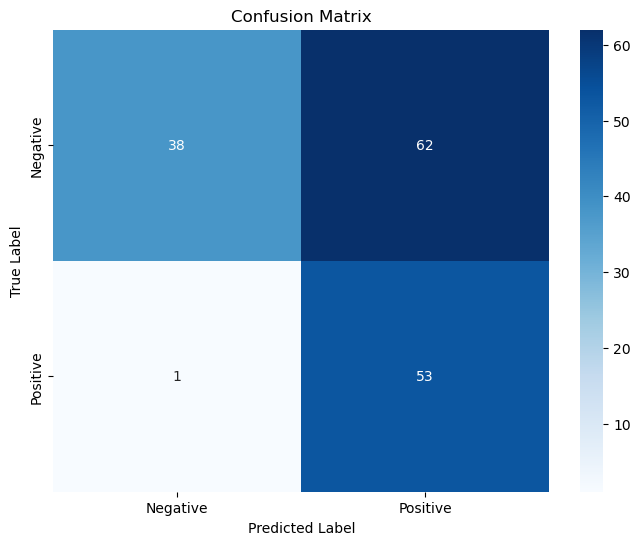

In [207]:
#threshold 0.47

from sklearn.metrics import confusion_matrix
# Predict the labels
y_pred = best_pipeline["Adaboost"].predict_proba(X_test)[:,1]

y_pred = (y_pred>0.47).astype(int)
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


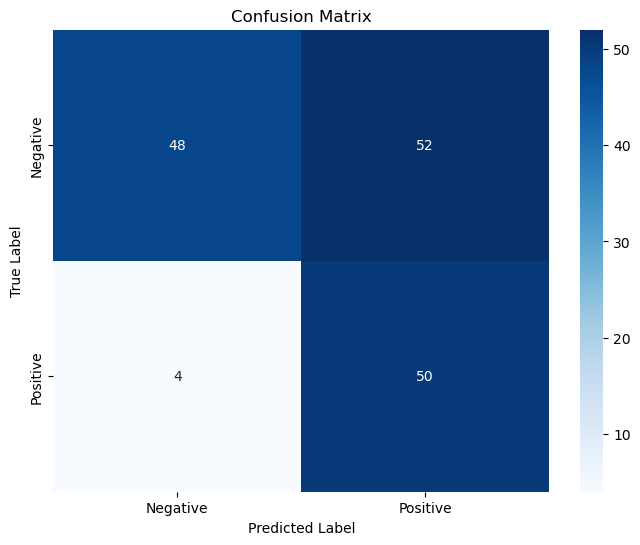

In [211]:
#threshold 0.48

from sklearn.metrics import confusion_matrix
# Predict the labels
y_pred = best_pipeline["Adaboost"].predict_proba(X_test)[:,1]

y_pred = (y_pred>0.475).astype(int)
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

- Threshold 0.47 and 0.48 will be best for building model in ADABOOST
- These Value Give us Less False Negative Rate And High over All Accuracy